# Model review - GiveMeCredit - Deepnet

#### *Fonctions*

In [16]:
def threshold(row):
    if row['1 probability'] < threshold_value:
        prediction_value = 0
    else: 
        prediction_value = 1
    return prediction_value

def error_column(row):
    if(row['SeriousDlqin2yrs'] == 0 and row['prediction'] == 0):
        error_value = 'TN'
    if(row['SeriousDlqin2yrs'] == 1 and row['prediction'] == 0):
        error_value = 'FN'
    if(row['SeriousDlqin2yrs'] == 0 and row['prediction'] == 1):
        error_value = 'FP'
    if(row['SeriousDlqin2yrs'] == 1 and row['prediction'] == 1):
        error_value = 'TP'
    return error_value

def confusion_matrix():
    idx = pd.Index(df['error'])
    count_matrix = idx.value_counts() 
    return count_matrix

def get_accuracy():
    matrix = list(df.error.values)
    tn = matrix.count('TN')
    fn = matrix.count('FN')
    tp = matrix.count('TP')
    fp = matrix.count('FP')
    total = tn + fn + tp + fp
    accuracy = ((tp + tn ) / total ) * 100
    return accuracy

def get_profits():
    matrix = list(df.error.values)
    val_tn = 500
    val_fn = -2500
    val_tp = 0
    val_fp = -500
    profits = matrix.count('TN') * val_tn + matrix.count('FN') * val_fn + matrix.count('TP') * val_tp + matrix.count('FP') * val_fp
    return profits

# On cherche parmis les FN ( Prediction = 0 , Réalité  = 1 ) les plus petites 1 Proba ( Le modele prédisait quasi certainement 0)
def biggest_mistakes():
    filtered = df.loc[df['error'].isin(["FN"])]
    filtered = (filtered.nsmallest(100, '1 probability'))
    filtered.to_csv("files_csv/100_biggest_mistakes.csv")


def matrix(threshold): 
    # Return True si 1 Proba > seuil & False si 1 Proba < seuil
    prediction_threshold = df['1 probability'] > threshold
    
    P_pred = prediction_threshold # Renvoie True si 1 proba > seuil ( sinon False )
    N_pred = ~prediction_threshold # Renvoie True si 1 proba < seuil ( sinon False )
    
    P_real = (df['SeriousDlqin2yrs'] == 1) # Renvoie True si SeriousDlqin2Yrs == 1 ( sinon False )
    N_real = (df['SeriousDlqin2yrs'] == 0) # Renvoie True si SeriousDlqin2Yrs == 0 ( sinon False )
    
    # P_pred True si 1 proba > seuil Prediction =  1 , P_real True si Realite = 1 
    TP = len(df.loc[P_pred & P_real])
    # N_pred True = si 1 proba < seuil = Prediction = 0 , N_real True si Realité 0 
    TN = len(df.loc[N_pred & N_real])
    # P_pred True si 1 proba > seuil Prediction = 1 , N_real True si Réalite = 0
    FP = len(df.loc[P_pred & N_real])
    # N_pred True si 1 proba < seuil =  Prediction 0 , P_real True si Realité = 1
    FN = len(df.loc[N_pred & P_real])
    
    matrix = []
    matrix.append(int(TP))
    matrix.append(int(TN))
    matrix.append(int(FP))
    matrix.append(int(FN))
    
    return matrix
    
def cost_threshold(threshold):
    matrix_list = matrix(threshold)
    
    TP = matrix_list[0]
    TN = matrix_list[1]
    FP = matrix_list[2]
    FN = matrix_list[3]
    
    TP_cost = 0
    FN_cost = -2500
    FP_cost = -500
    TN_cost = 500
    
    cost = TP * TP_cost
    cost += TN * TN_cost
    cost += FP * FP_cost
    cost += FN * FN_cost
    
    return cost

# FPR ( False positive Rate ) => FP /  (FP + TN) => On prédit 1 réalité 0 /  Toutes les fois ou à la réalité = 0 
def false_positive_rate(threshold):
    matrix_list = matrix(threshold)
    
    TP = matrix_list[0]
    TN = matrix_list[1]
    FP = matrix_list[2]
    FN = matrix_list[3]
    
    fpr = (FP / ( FP + TN )) * 100
    return fpr 

# TPR ( True positive Rate ) => TP / ( TP + FN ) => On prédit 1 réalité 1 / Toutes les fois ou la réalité = 1 
def true_positive_rate(threshold):
    matrix_list = matrix(threshold)
    
    TP = matrix_list[0]
    TN = matrix_list[1]
    FP = matrix_list[2]
    FN = matrix_list[3]
    
    tpr = (TP / ( TP + FN )) * 100
    return tpr 

#### *Définition du seuil*

In [17]:
threshold_value = 0.5

#### *Chargement de la feuille csv & applications des modifications*

In [18]:
import pandas as pd 


df = pd.read_csv('files_csv/GiveMeCredit_Review_Deepnet.csv', index_col=0)
df.rename(columns={"SeriousDlqin2yrs.1": "prediction"}, inplace= True)
df['prediction'] = df.apply(threshold, axis = 1)
df['error'] = df.apply(error_column, axis = 1)
print("Load & Modifications : OK")

Load & Modifications : OK


#### *Graphique seuil => gain et seuil opti*

gain max 9904500 $ | Seuil 0.335


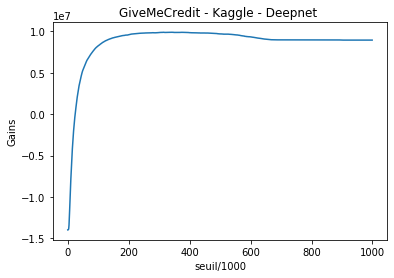

In [19]:
import matplotlib.pyplot as plt
# on fait varier le seuil de 0 à 1000 / 1000 => 0.0001 , 0.0002 ... 1 dans la fonction seuil => gain
table = [cost_threshold(n/1000) for n in range(0,1000)]
plt.xlabel("seuil/1000")
plt.ylabel("Gains")
plt.title("GiveMeCredit - Kaggle - Deepnet ")

plt.plot(table)

max_val = max(table)
max_threshold = table.index(max_val)/1000
print(f'gain max {max_val} $ | Seuil {max_threshold}')

#### *Calcul AUC*

In [20]:
from sklearn.metrics import roc_auc_score


actual = df['SeriousDlqin2yrs']
scores = df['1 probability']
auc = roc_auc_score(actual, scores)
print(auc)

0.8428967131009123


#### *ROC CURVE*

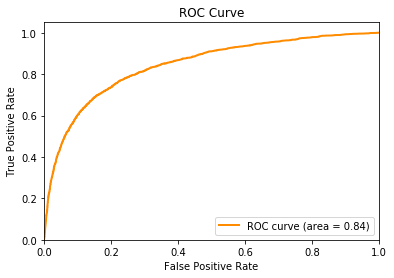

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt

actual = df['SeriousDlqin2yrs']
scores = df['1 probability']
fpr, tpr, thresholds = metrics.roc_curve(actual, scores, pos_label=1)
auc = metrics.roc_auc_score(actual,scores)
plt.figure()
lw = 2 
# plt.plot(fpr,tpr, color='darkorange', lw = lw, label='ROC curve ( area = %0.2f)' %auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()